In [271]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
import seaborn as sns
from collections import Counter

"""
Note: Never train your model on the entire data set
You need to split the data into test data and validation data to make sure that
you're able to train the model but also make predictions with it based on data
from the dataset its never seen before.
"""

# This will split your data set in the way we need for training.
from sklearn.model_selection import train_test_split

# For predictions
from sklearn.linear_model import LogisticRegression

# Will be used to get some stats on the model's predictions
from sklearn.metrics import classification_report

In [272]:
df = pd.read_csv("Titanic-Dataset.csv")

In [273]:
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [274]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [275]:
# Cleaning data:
# Filling empty age values with median age (assumption)
main_stats = df.describe()
med_age = (main_stats['Age']['50%'])

age_col = df['Age']
age_col = age_col.fillna(med_age)

df['Age'] = age_col

# Getting rid of less useful columns.
# Axis 1 refers to the very first row where the column names are, this checks "Cabin" in said row.
df = df.drop('Cabin', axis=1)
df = df.drop('Fare', axis=1)
df = df.drop('Embarked', axis=1)
df = df.drop('Ticket', axis=1)
df = df.drop('Parch', axis=1)
df = df.drop('SibSp', axis=1)
df = df.drop('Name', axis=1)
df = df.drop('PassengerId', axis=1)


df = df.replace('male', 0.0)
df = df.replace('female', 1.0)

df


/tmp/ipython-input-3635637255.py:24: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace('female', 1.0)


,Survived,Pclass,Sex,Age
0,0,3,0.0,22.0
1,1,1,1.0,38.0
2,1,3,1.0,26.0
3,1,1,1.0,35.0
4,0,3,0.0,35.0
...,...,...,...,...
886,0,2,0.0,27.0
887,1,1,1.0,19.0
888,0,3,1.0,28.0
889,1,1,0.0,26.0


In [276]:
# Gather your dependent and independent cols:
# We're using multiple cols to predict Y so we extract a part of the dataframe
Independents = df[['Pclass', 'Sex', 'Age']]

# The column we're going to be predicting
Dependents = df.iloc[:, 0]

In [277]:
# Splitting up test and training variables | 80/20
# Basically makes four separate data frames. 2 of which are for training and 2 of which are for testing.
x_training, x_testing, y_training, y_testing = train_test_split(Independents, Dependents, train_size=0.8, random_state=10)

In [278]:
# Initialize Logistic Regression Model

log = LogisticRegression()

# Give the model the training data:
log.fit(x_training, y_training)

LogisticRegression()

In [279]:
survival_predictions = log.predict(x_testing)
log.score(x_testing, y_testing)

0.8324022346368715

In [280]:
print(classification_report(survival_predictions, y_testing))

              precision    recall  f1-score   support

           0       0.88      0.87      0.87       119
           1       0.74      0.77      0.75        60

    accuracy                           0.83       179
   macro avg       0.81      0.82      0.81       179
weighted avg       0.83      0.83      0.83       179



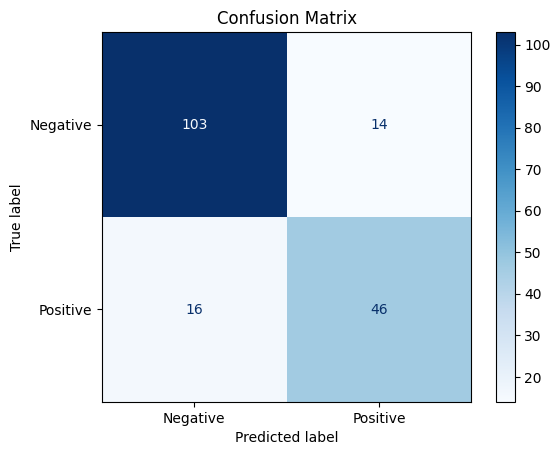

In [281]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# y_testing and survival_predictions are available from your previous code cells

# 1. Compute the confusion matrix
cm = confusion_matrix(y_testing, survival_predictions)

# 2. Define the class labels (e.g., Non-Survival, Survival)
labels = ["Negative", "Positive"]

# 3. Plot the matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

The logistic regression model performed better at predicting that a passenger would not survive than if they would. This is likely because the total number of passengers who died is far greater than the amount who survived. Additionally there's very few variables contributing to someone's survival so accurately predicting who actually would survive is a harder task seeing as that's a much smaller group of people.

Stats from test sample:
103/119 Correctly Predicted Deaths | 46/60 Correctly Predicted Survivals

<function matplotlib.pyplot.show(close=None, block=None)>

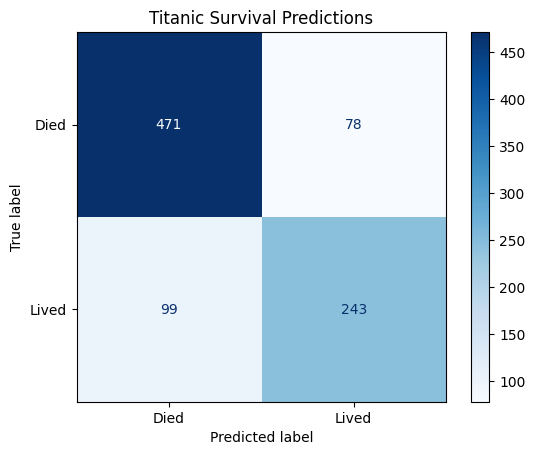

In [282]:
# Using the model on the entire dataset

true_predictions = log.predict(Independents)
log.score(Independents, Dependents)

# Build confusion matrix again
cm = confusion_matrix(Dependents, true_predictions)

# Class labels (died or survived)
labels = ['Died', 'Lived']

graph = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
graph.plot(cmap=plt.cm.Blues)
plt.title("Titanic Survival Predictions")
plt.show

In [283]:
predicted_col = pd.DataFrame(true_predictions)

# Return only the values where a passenger was predicted to survive:
predicted_col = predicted_col.loc[predicted_col[0] == 1]
predicted_col

passengerIDs = []
for x in predicted_col.index.values:
  passengerIDs.append(int(x))

predicted_survivors_df = Independents.iloc[passengerIDs]
predicted_survivors_df

,Pclass,Sex,Age
1,1,1.0,38.0
2,3,1.0,26.0
3,1,1.0,35.0
8,3,1.0,27.0
9,2,1.0,14.0
...,...,...,...
880,2,1.0,25.0
882,3,1.0,22.0
887,1,1.0,19.0
888,3,1.0,28.0


In [284]:
def MostFrequentValues(dataframe, category):

  df = dataframe[[category]]

  # Where we'll store the values we're going to be sifting through
  res = []

  # Using iterrows()
  for index, row in df.iterrows():
      # index will be the row label (1, 2, 3, etc.)
      # row will be a Pandas Series containing the column data (e.g., {'Age': 38.0})
      cat_value = row[category]

      # print(f"Row Index: {index}, {category} Value: {cat_value}")
      res.append(int(cat_value))

  counter = Counter(res)
  return (counter.most_common())




In [290]:
# Assuming your DataFrame is called 'df'
High1 = MostFrequentValues(predicted_survivors_df, "Pclass")[0]
High2 = MostFrequentValues(predicted_survivors_df, "Age")[0]
High3 = MostFrequentValues(predicted_survivors_df, "Sex")[0]

print(High1,High2,High3)


(3, 132) (28, 60) (1, 302)


What does this mean? According to the model If you were a lower class woman around the age of 28 years old you'd be most likely to survive. The highest amount of suvivors were yielded from these groups.

This is likely because of the titanics "women and children first" protocol in case of emergency. Many young women regardless of class were funneled onto boats first along with children. However it is a stretch to say lower class women had a higher chance of surviving than upper class women. The model likely comes to this conclusion because the number of lower class women on the boat probably far outnumbers the amount of upper class women present. If we compare the number of upper class female survivors vs lower class female survivors we might find that the surival rate amongst upper class women was higher since they were top priority.